# Overview notebook

***Note for using this notebook:***

If you want to run the notebook yourself, please set the variable `path_to_ray_results` in the second codecell to the path to the ray_results which can be downloaded on sciebo.

In [2]:
# some imports
import torch
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import os
import sys
sys.path.insert(0, '../')
from dataloader import KITTIloader, listflowfile
from modules.our_net import OurNet
from training.loss_functions import smoothL1, three_pixel_err
from my_utils import load_tune_checkpoint

In [3]:
# load data
device = 'cuda'

path_to_ray_results = '../../../submission/ray_results/'

kitti_test_set = KITTIloader.KittiDataset('test')

kitti_val_set = KITTIloader.KittiDataset('val')

kitti_test = torch.utils.data.DataLoader(dataset=KITTIloader.KittiDataset('test'), 
                                                        batch_size=1, 
                                                        shuffle=True)

kitti_val = torch.utils.data.DataLoader(dataset=KITTIloader.KittiDataset('val'), 
                                                        batch_size=1, 
                                                        shuffle=True)

In [4]:
# Function to calculate loss and error on validation and test data
@torch.no_grad()
def evaluate_model(model, dataloader):
    loss_func = smoothL1(1.0)
    model.eval()
    
    losses = []
    errs = []
    
    for left, right, target in dataloader:
        left = left.to(device)
        right = right.to(device)
        target = target.to(device)
        prediction = model(left, right)
        losses.append(loss_func(target, prediction).item())
        errs.append(three_pixel_err(target, prediction).item())
            
    print('Smooth L1 loss: ', np.mean(losses))
    print('3 pixel error: ', np.mean(errs))

In [5]:
imagenet_stats = {'mean': np.array([0.485, 0.456, 0.406]),
                   'std': np.array([0.229, 0.224, 0.225])}

In [6]:
# unnormalization to show images
unnormalize = T.Normalize((-imagenet_stats['mean']/ imagenet_stats['std']).tolist(), (1.0 / imagenet_stats['std']).tolist())

In [7]:
# Function to show output of a model

@torch.no_grad()
def show_output(model, dataloader=kitti_test, n=5):
    fig, axs = plt.subplots(nrows=n, ncols=6, squeeze=False, figsize=(22,2.5*n))
    
    dataloader = iter(dataloader)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=192)
    to_numpy = lambda x: np.asarray(x.cpu())

    
    for row in range(n):
        left, right, disp = next(dataloader)
        left = left.to(device)
        right = right.to(device)
        disp = disp.to(device)
        
        pred = model(left, right)
        
        left = to_numpy(unnormalize(torch.squeeze(left, 0)))
        right = to_numpy(unnormalize(torch.squeeze(right, 0)))
        disp = to_numpy(torch.squeeze(disp, 0))
        pred = to_numpy(torch.squeeze(pred, 0))
        mask = (disp!=0.0)
        difference = np.abs(pred-disp)
        difference[disp==0.0]=np.zeros((disp==0.0).sum())
        
        axs[row, 0].set(title='Original image left')
        axs[row, 1].set(title='Original image right')
        axs[row, 2].set(title='True disparity')
        axs[row, 3].set(title='Predicted disparity')
        axs[row, 4].set(title='Where disparity is not available\n(colored black)')
        axs[row, 5].set(title='Difference true and predicted disparity\n(where predicted disparity is available)')
        
        for ax in axs[row, :]:
            ax.axis('off')
            ax.title.set_size(10)
        
        
        axs[row, 0].imshow(np.transpose(left, (1,2,0)))
        axs[row, 1].imshow(np.transpose(right, (1,2,0)))
        axs[row, 2].imshow(disp, norm=norm, interpolation='nearest')
        axs[row, 3].imshow(pred, norm=norm)
        axs[row, 4].imshow(mask, cmap='gray', interpolation='nearest')
        axs[row, 5].imshow(difference, norm=norm, interpolation='nearest')
        
    plt.tight_layout()
    cmap = mpl.cm.viridis
    
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='horizontal', label='disparity')


## Deep model

In [8]:
layers = {'feat': [3,32,64,128,128,256,256,512,32], 'cost': [64,32,32,32,32,32,32,32,1]}

In [9]:
pretrain_path = os.path.join(path_to_ray_results, 'experiment_3_finetune/train_0ca00_00000_0_2021-09-11_16-53-39/checkpoint_000150/checkpoint')

In [10]:
# load the pretrained finetuned model
model = OurNet(channel_fe=layers['feat'], channel_cp=layers['cost'],
               dropout_p=0).to(device)
load_tune_checkpoint(model, pretrain_path)

The validation loss and error

In [11]:
evaluate_model(model, kitti_val)

/home/user/brank/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torchvision/transforms/functional.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))
/home/user/brank/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.w

Smooth L1 loss:  0.5645790231227875
3 pixel error:  0.036268701553344725


The test loss and error

In [12]:
evaluate_model(model, kitti_test)

Smooth L1 loss:  0.7702340316772461
3 pixel error:  0.05000158786773681


#### Show outputs

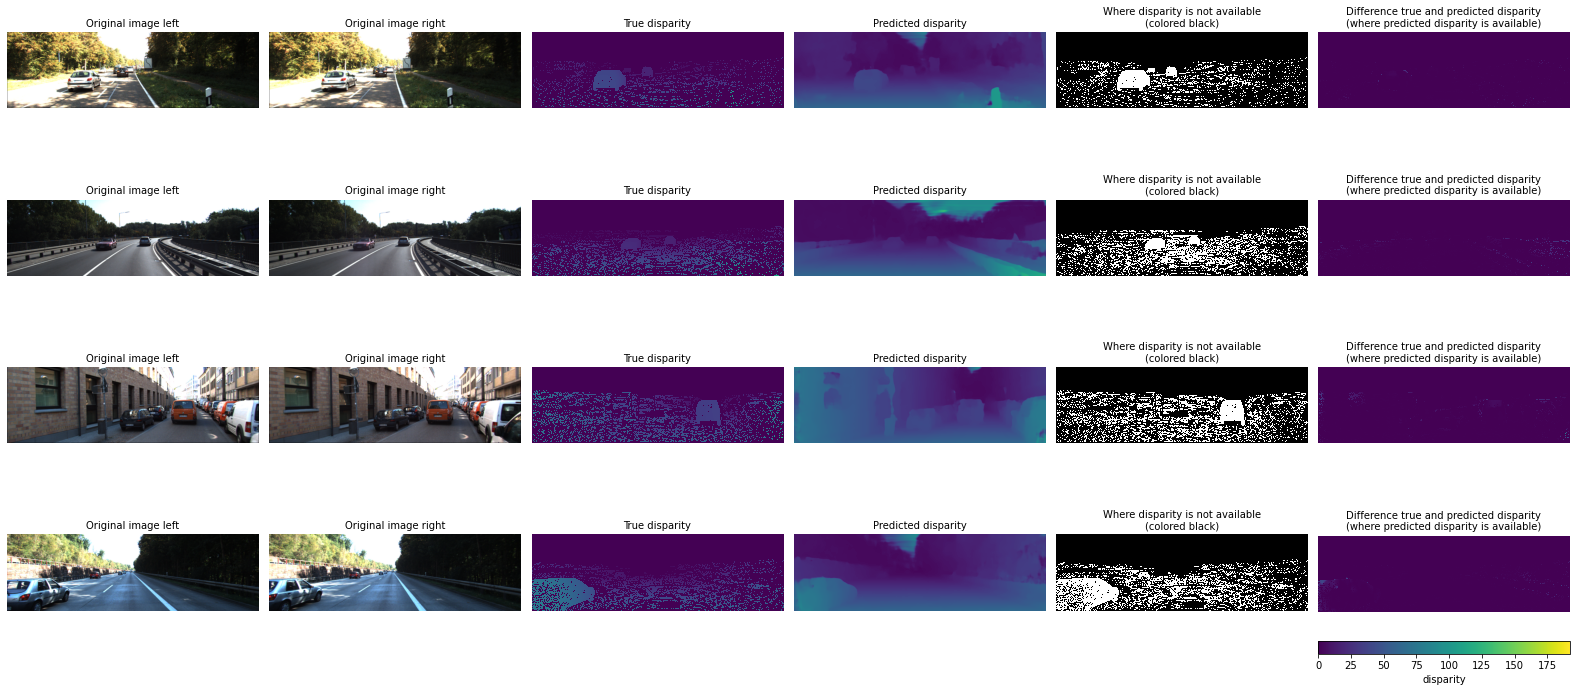

In [13]:
show_output(model, dataloader=kitti_test, n=4)

## Population Based Training

In [14]:
layers = {'feat': [3,32,64,64,128,128,256,256,32], 'cost': [64,32,32,32,32,32,1]}

### Population Based Training with Adam optimizer

In [15]:
pretrain_path = os.path.join(path_to_ray_results, 'experiment_4/train_0204a_00006_6_dropout_p=0.2561,lr=1.0276e-05_2021-09-14_04-03-19/checkpoint_000270/checkpoint')

In [16]:
# load the pretrained finetuned model
model = OurNet(channel_fe=layers['feat'], channel_cp=layers['cost'],
               dropout_p=0).to(device)
load_tune_checkpoint(model, pretrain_path)

The validation loss and error

In [17]:
evaluate_model(model, kitti_val)

Smooth L1 loss:  0.5317463612556458
3 pixel error:  0.033611021041870116


The test loss and error

In [18]:
evaluate_model(model, kitti_test)

Smooth L1 loss:  0.7976861935853958
3 pixel error:  0.05090273380279541


#### Show outputs

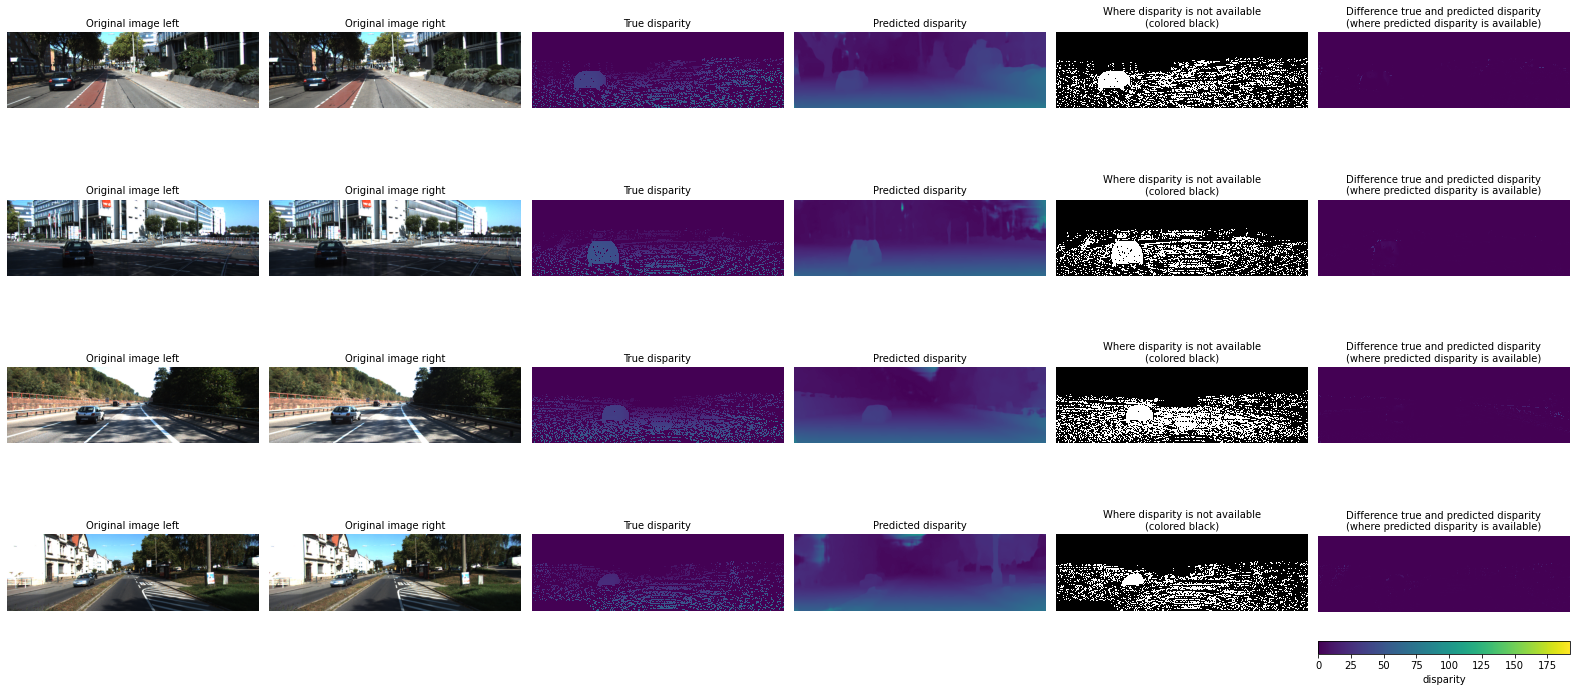

In [19]:
show_output(model, dataloader=kitti_test, n=4)

### Population Based Training with SGD

In [20]:
layers = {'feat': [3,32,64,64,128,128,256,256,32], 'cost': [64,32,32,32,32,32,1]}

In [21]:
pretrain_path = os.path.join(path_to_ray_results, 'experiment_5/train_53ab0_00002_2_dropout_p=0.38027,lr=3.9282e-05,momentum=0.83365_2021-09-14_11-35-43/checkpoint_000270/checkpoint')

In [22]:
# load the pretrained finetuned model
model = OurNet(channel_fe=layers['feat'], channel_cp=layers['cost'],
               dropout_p=0).to(device)
load_tune_checkpoint(model, pretrain_path)

The validation loss and error

In [23]:
evaluate_model(model, kitti_val)

Smooth L1 loss:  0.6908847868442536
3 pixel error:  0.045602455139160156


The test loss and error

In [24]:
evaluate_model(model, kitti_test)

Smooth L1 loss:  1.0478936266899108
3 pixel error:  0.06597841262817383


#### Show outputs

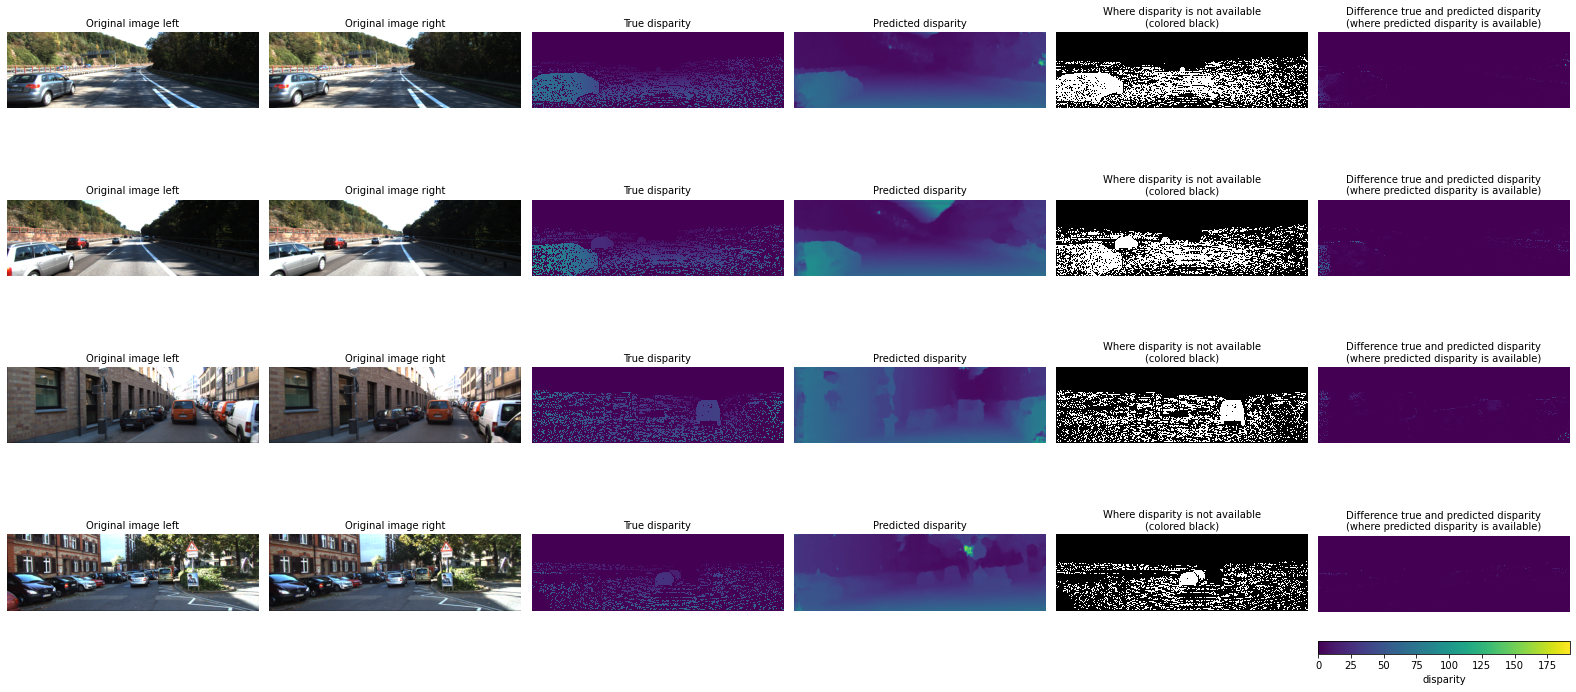

In [25]:
show_output(model, dataloader=kitti_test, n=4)